In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm 

In [3]:
dir_github = '/media/rich/Home_Linux_partition/github_repos/'
import sys
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from NBAP.pipeline_2pRAM_faceRhythm.classify_ROIs import util
from NBAP.pipeline_2pRAM_faceRhythm.classify_ROIs.network import model

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import decomposition, classification, pickle_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import labeled data

In [4]:
paths_labelStat = [
    {
        'label': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouse2_6__20210409/labels_round2_sesh2.npy',
        'stat': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouse2_6__20210409/stat.npy'
    },
#     {
#         'label': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouse6_28 _ day20200815//labels_posthoc_all.npy', 
#         'stat': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouse6_28 _ day20200815/stat.npy'
#     },
#     {
#         'label': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy', 
#         'stat': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouse 6_28 _ day 20200903/stat.npy'
#     },
#     {
#         'label': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouseUnknownAi148__20210325/labels_posthoc_mouseUnknownAi148__20210325.npy',
#         'stat': '/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/mouseUnknownAi148__20210325/stat.npy'
#     },
]

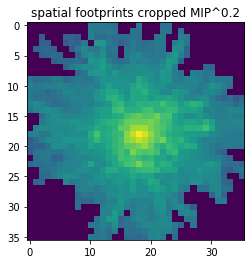

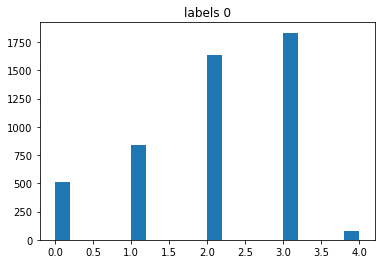

In [5]:
sf_all = util.import_multiple_stat_files(   
    paths_statFiles=[item['stat'] for item in paths_labelStat],
    out_height_width=[36,36],
    max_footprint_width=1441,
    plot_pref=True
)


labels = util.import_multiple_label_files(paths_labelFiles=[item['label'] for item in paths_labelStat])
# labels_cat = np.concatenate(labels)

In [6]:
def convert_old_labels_to_new_labels(labels_old):
    import copy
    labels_new = copy.copy(labels_old)
    labels_new[labels_new==4] = 2
    labels_new[labels_new==5] = 3
    return labels_new

# # labels[0] = convert_old_labels_to_new_labels(labels[0])
# labels[1] = convert_old_labels_to_new_labels(labels[1])
# labels[2] = convert_old_labels_to_new_labels(labels[2])
# labels[3] = convert_old_labels_to_new_labels(labels[3])

In [7]:
def remove_samples_with_given_label(images, labels, label_toRemove):
    import copy
    im_out = copy.copy(images)
    labels_out = copy.copy(labels)
    
    idx_toRemove = (labels_out==label_toRemove)
    im_out = im_out[~idx_toRemove]
    labels_out = labels_out[~idx_toRemove]
    
    return im_out, labels_out
    
tmp_sf_and_labels = [remove_samples_with_given_label(sf, labs, 4) for (sf, labs) in zip(sf_all, labels)]
sf_all_cleaned, labels_cleaned = [item[0] for item in tmp_sf_and_labels] , [item[1] for item in tmp_sf_and_labels]

sf_labeled_cat = np.concatenate(sf_all_cleaned, axis=0)
labels_cat = np.concatenate(labels_cleaned)
assert np.alltrue(sf_labeled_cat.shape[0] == len(labels_cat)) , 'num images in stat files does not correspond to num labels'

# labels_cat = labels_cat[~idx_toRemove]
# sf_labeled_cat = sf_labeled_cat[~idx_toRemove]

In [8]:
sf_labeled_cat.shape

(4821, 36, 36)

In [9]:
sf_ptiles = np.array([np.percentile(np.sum(sf>0, axis=(1,2)), 90) for sf in tqdm(sf_all_cleaned)])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.35it/s]


In [10]:
scales_forRS = (250/sf_ptiles)**0.5

In [11]:
import PIL
sf_concat_rs = np.concatenate([np.stack([util.resize_affine(img, scale=scales_forRS[ii], clamp_range=True) for img in sf], axis=0) for ii, sf in enumerate(tqdm(sf_all_cleaned))], axis=0)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


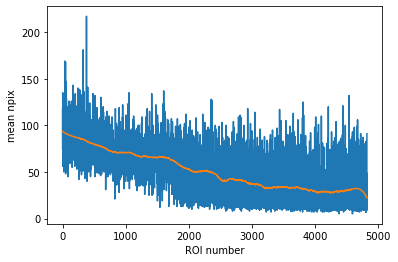

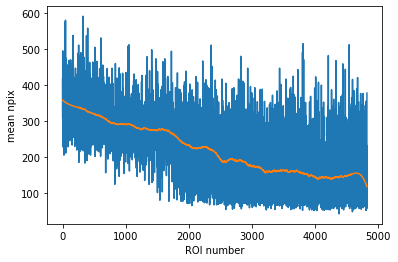

In [12]:
import scipy.signal

plt.figure()
plt.plot(np.sum(sf_labeled_cat > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_labeled_cat > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(sf_concat_rs > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_concat_rs > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

In [13]:
transforms_classifier = torch.nn.Sequential(
    util.ScaleDynamicRange(scaler_bounds=(0,1)),
    
    torchvision.transforms.Resize(
        size=(224, 224),
#         size=(180, 180),
#         size=(72, 72),        
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    
    util.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_classifier = torch.jit.script(transforms_classifier)


In [14]:
dataset_labeled = util.dataset_simCLR(
        X=torch.as_tensor(sf_concat_rs, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(sf_concat_rs.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    
dataloader_labeled = out = torch.utils.data.DataLoader( 
        dataset_labeled,
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=36,
        persistent_workers=True,
#         prefetch_factor=2
)

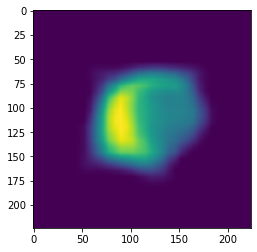

In [15]:
plt.figure()
plt.imshow(dataset_labeled[0][0][0][0])

In [16]:
path_params = '/media/rich/Home_Linux_partition/github_repos/NBAP/pipeline_2pRAM_faceRhythm/classify_ROIs/network/params.json'

In [17]:
import json

with open(path_params) as f:
    params = json.load(f)


In [18]:
params

{'pref_log_all_steps': True,
 'paths': {'dir_github': '/n/data1/hms/neurobio/sabatini/rich/github_repos',
  'fileName_save_model': 'ConvNext_tiny__1_0_unfrozen__simCLR',
  'path_data_training': '/n/data1/hms/neurobio/sabatini/rich/data/ROI_network_data/sf_sparse_36x36_20220503.npz'},
 'prefs': {'saveModelIteratively': True, 'saveLogs': True},
 'useGPU_training': True,
 'useGPU_dataloader': False,
 'dataloader_kwargs': {'batch_size': 1024,
  'shuffle': True,
  'drop_last': True,
  'pin_memory': True,
  'num_workers': 4,
  'persistent_workers': True,
  'prefetch_factor': 1},
 'inner_batch_size': 256,
 'torchvision_model': 'convnext_tiny',
 'pre_head_fc_sizes': [256, 128],
 'post_head_fc_sizes': [128],
 'block_to_unfreeze': '6.0',
 'n_block_toInclude': 9,
 'head_nonlinearity': 'GELU',
 'lr': 0.0031622776601683794,
 'penalty_orthogonality': 0.0,
 'weight_decay': 0.0,
 'gamma': 1.0,
 'n_epochs': 9999999,
 'temperature': 0.1,
 'l2_alpha': 0.0,
 'augmentation': {'Scale_image_sum': {'sum_val':

In [19]:
[params['augmentation']['TileChannels']['n_channels']] + params['augmentation']['WarpPoints']['img_size_out']

[3, 224, 224]

In [20]:
model = model.make_model(
    torchvision_model=params['torchvision_model'],
    n_block_toInclude=params['n_block_toInclude'],
    pre_head_fc_sizes=params['pre_head_fc_sizes'],
    post_head_fc_sizes=params['post_head_fc_sizes'],
    head_nonlinearity=params['head_nonlinearity'],
    image_shape=[3, 224, 224],
#     image_shape=[params['augmentation']['TileChannels']['n_channels']] + params['augmentation']['WarpPoints']['img_size_out']
);

In [21]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

In [22]:
model.load_state_dict(torch.load('/media/rich/Home_Linux_partition/github_repos/NBAP/pipeline_2pRAM_faceRhythm/classify_ROIs/network/ConvNext_tiny__1_0_unfrozen__simCLR.pth'))

<All keys matched successfully>

In [23]:
DEVICE = 'cuda:0'

In [24]:
model = model.to(DEVICE)

In [25]:
features_nn = torch.cat([model(data[0][0].to(DEVICE)).detach() for data in tqdm(dataloader_labeled)], dim=0).cpu()

100%|█████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


In [26]:
def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

In [27]:
from kymatio import Scattering2D

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


device_model = util.set_device(use_GPU=True)

scattering = Scattering2D(J=2, L=8, shape=sf_concat_rs[0].shape[-2:])
if device_model != 'cpu':
    scattering = scattering.cuda()

latents_swt = get_latents_swt(sf_concat_rs, scattering.cuda(), device_model).cpu()

device: 'cuda:0'


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


In [28]:
import scipy.stats

<IPython.core.display.Javascript object>


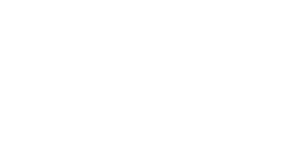

In [29]:
%matplotlib notebook
plt.figure()
plt.imshow(features_nn, aspect='auto',)

<IPython.core.display.Javascript object>


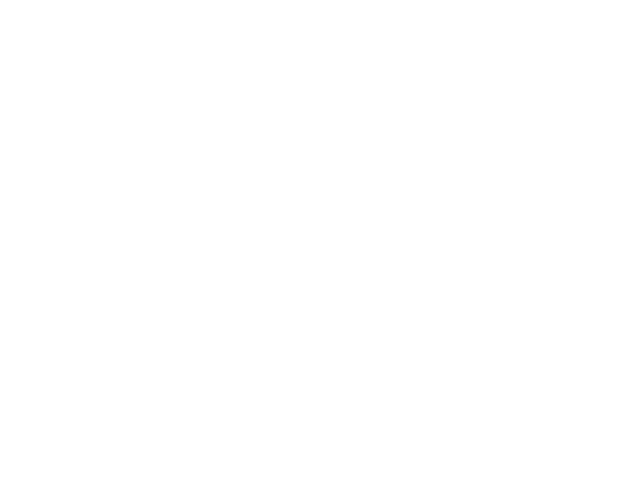

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/scipy/stats/stats.py:2555: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  z[np.broadcast_to(isconst, z.shape)] = np.nan


In [30]:
%matplotlib notebook
plt.figure()
plt.imshow(scipy.stats.zscore(features_nn, axis=0), aspect='auto', vmin=-0.8, vmax=1,)

In [31]:
features_nn_z = scipy.stats.zscore(features_nn.numpy(), axis=0)
features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)

In [32]:
n_pcs_toKeep_nn = 40
n_pcs_toKeep_swt = 10

# comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=30, zscore=True)
comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, rank=n_pcs_toKeep_nn, zscore=False)
comp_swt, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=n_pcs_toKeep_swt)
comp, scores_image, SVs, EVR_image = decomposition.torch_pca(sf_concat_rs.reshape(sf_concat_rs.shape[0], -1), rank=5)

<IPython.core.display.Javascript object>


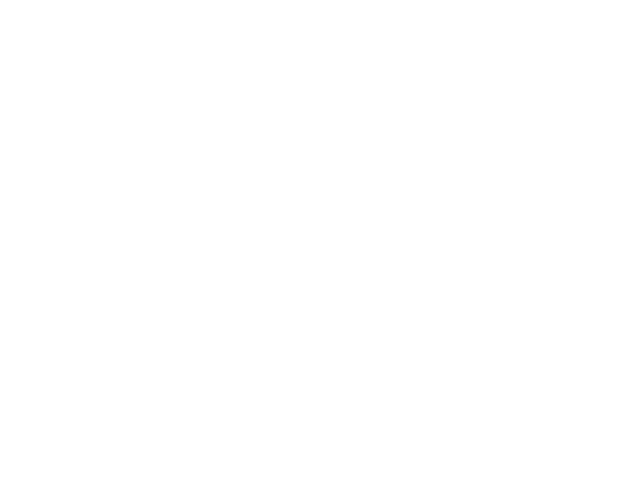

In [33]:
plt.figure()
plt.plot(EVR_nn)
plt.yscale('log')

<IPython.core.display.Javascript object>


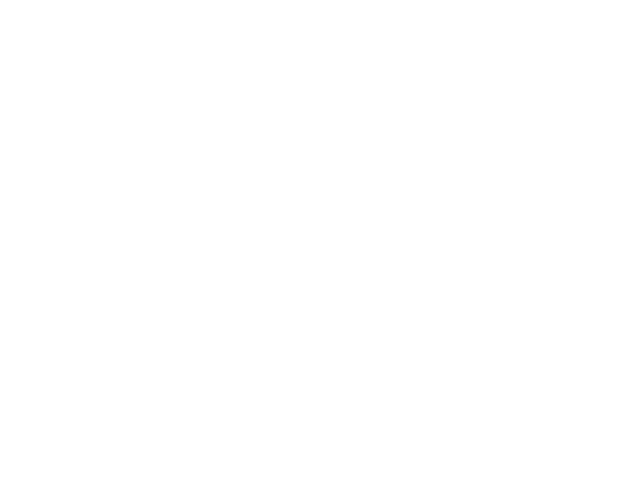

In [34]:
plt.figure()
plt.imshow(torch.corrcoef(features_nn.T))

In [35]:
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_image]], dim=1)
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt, scores_image]], dim=1)

In [36]:
import sklearn
features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(features_norm, labels_cat, test_size=0.2)
# features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(scores_nn, labels_cat, test_size=0.2)
# features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(torch.cat([scores_nn, scores_swt], dim=1), labels_cat, test_size=0.2)
print(f'train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: {features_train.shape, features_val.shape, labels_cat.shape, labels_cat.shape}')

train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([3856, 50]), torch.Size([965, 50]), (4821,), (4821,))


In [37]:
acc_train, acc_val = [], []
C_toUse = np.array([1000, 100, 10,1,0.1,0.01,0.001])
# C_toUse = np.array([10, 1])
# C_toUse = np.array([10**-4, 10**-5, 10**-6, 10**-7])
# C_toUse = np.array([10**2, 10**3, 10**4, 10**5])
for C in C_toUse:
    logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solve='sag'
#         solve='saga'
#         solver='newton-cg',
#         solver='liblinear',
        max_iter=6000, 
        C=C,
        fit_intercept=True, 
        class_weight='balanced',
    #     n_jobs=-1
    )
    logreg.fit(features_train, labels_train)

    acc = logreg.score(features_train, labels_train, sample_weight=get_balanced_sample_weights(labels_train))
    acc_train.append(acc)

    acc = logreg.score(features_val, labels_val, sample_weight=get_balanced_sample_weights(labels_val))
    acc_val.append(acc)
    
    

best val score: 0.8346625773948682
best C value: 0.1


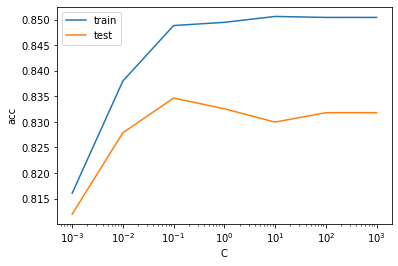

In [42]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

print(f'best val score: {max(acc_val)}')
print(f'best C value: {C_toUse[np.argmax(acc_val)]}')

In [39]:
logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solver='sag',
#         solver='saga',
#         solver='newton-cg',
#         solver='liblinear',
    max_iter=8000, 
    C=10**(-1),
    fit_intercept=True, 
    class_weight='balanced',
#     n_jobs=-1
).fit(features_train, labels_train)

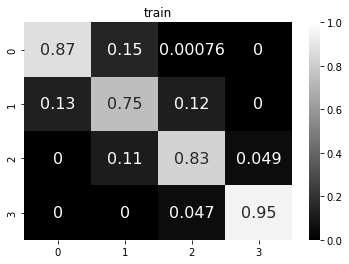

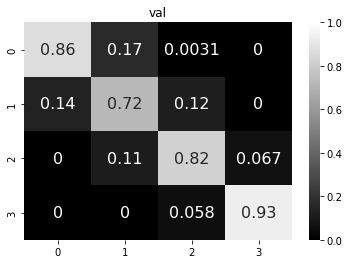

In [40]:
%matplotlib inline
import seaborn as sns

proba = logreg.predict_proba(features_train)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_train_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_train.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');



proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_val_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_val.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [43]:
## save logistic regression model

classifier = util.Classifier(
    logreg, 
    pca_preprocessing=True, 
    pc_loadings_nn=comp_nn,
    pc_loadings_swt=comp_swt,
    n_pcs_toKeep_nn=40,
    n_pcs_toKeep_swt=10,
)

classifier_vars = {
    'classifier': classifier,
    'sk_logreg': {
        'model_skl_logreg' : logreg,
        'coeff' : logreg.coef_,
        'intercepts' : logreg.intercept_,
        'classes' : logreg.classes_
    },
    'pca': {
        'n_pcs_toKeep_nn': n_pcs_toKeep_nn,
        'n_pcs_toKeep_swt': n_pcs_toKeep_swt,
        'comp_nn': comp_nn,
        'comp_swt': comp_swt,
    }
}

pickle_helpers.simple_save(classifier_vars, '/media/rich/Home_Linux_partition/github_repos/NBAP/pipeline_2pRAM_faceRhythm/classify_ROIs/classifier.pkl')

In [54]:
labels_sesh1 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy')
labels_sesh2 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy')

Text(0.5, 1.0, 'relabeling')

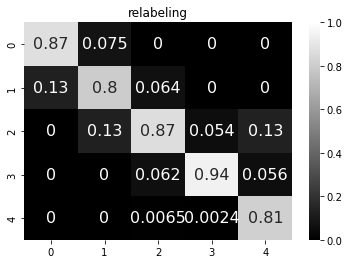

In [52]:
labels_sesh12cat = np.concatenate((labels_sesh1, labels_sesh2), axis=0)
labels_sesh21cat = np.concatenate((labels_sesh2, labels_sesh1), axis=0)
plt.figure()
sns.heatmap(
    classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32)),
    annot=True, 
    annot_kws={"size": 16}, 
    vmax=1., 
    cmap=plt.get_cmap('gray')
)
plt.title('relabeling')

In [43]:
from umap import UMAP
umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

In [44]:
emb_umap = umap.fit_transform(features_norm)
# emb_nn = umap.fit_transform(scores_nn)
# emb_swt = umap.fit_transform(latents_swt)

<IPython.core.display.Javascript object>


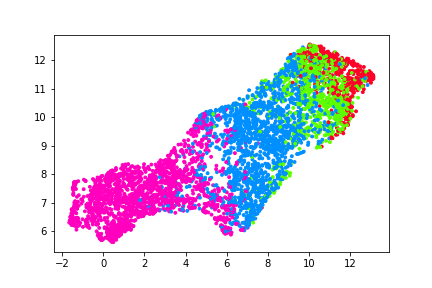

In [401]:
%matplotlib notebook

plt.figure()
plt.scatter(emb_umap[:,0], emb_umap[:,1], s=8, c=labels_cat, cmap='gist_rainbow')

<IPython.core.display.Javascript object>


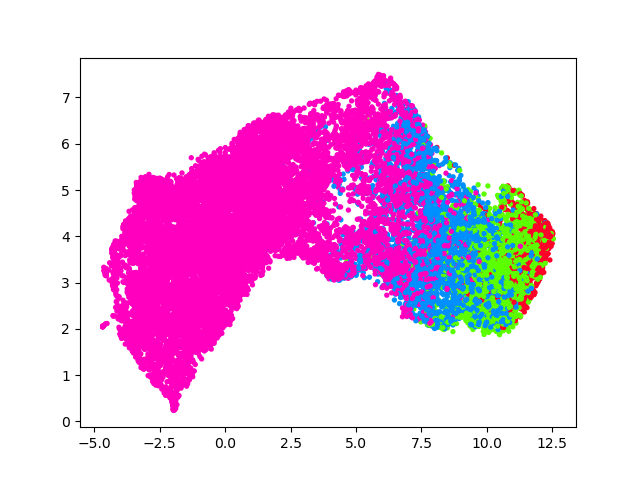

In [48]:
%matplotlib notebook

plt.figure()
plt.scatter(emb_umap[:,0], emb_umap[:,1], s=8, c=labels_cat, cmap='gist_rainbow')

In [46]:
emb_lr = logreg.predict_proba(features_norm)[:,[0,1]]

<IPython.core.display.Javascript object>


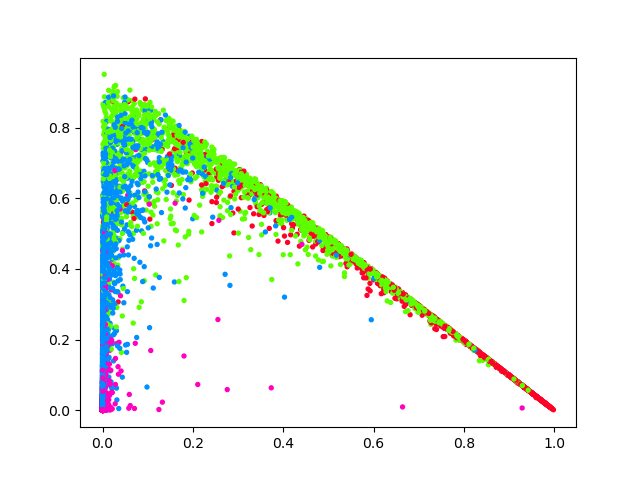

In [47]:
%matplotlib notebook

plt.figure()
plt.scatter(emb_lr[:,0], emb_lr[:,1], s=8, c=labels_cat, cmap='gist_rainbow')

In [50]:
bool_good, dist_mat_pruned = util.get_spread_out_points(emb_umap, thresh_dist=0.3, n_iter=10)
idx_good = np.nonzero(bool_good)[0]

/tmp/ipykernel_941375/2027185918.py:17: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:
/tmp/ipykernel_941375/2027185918.py:29: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(dist_mat_raw[idx][idx_good]) > thresh_dist:


<IPython.core.display.Javascript object>


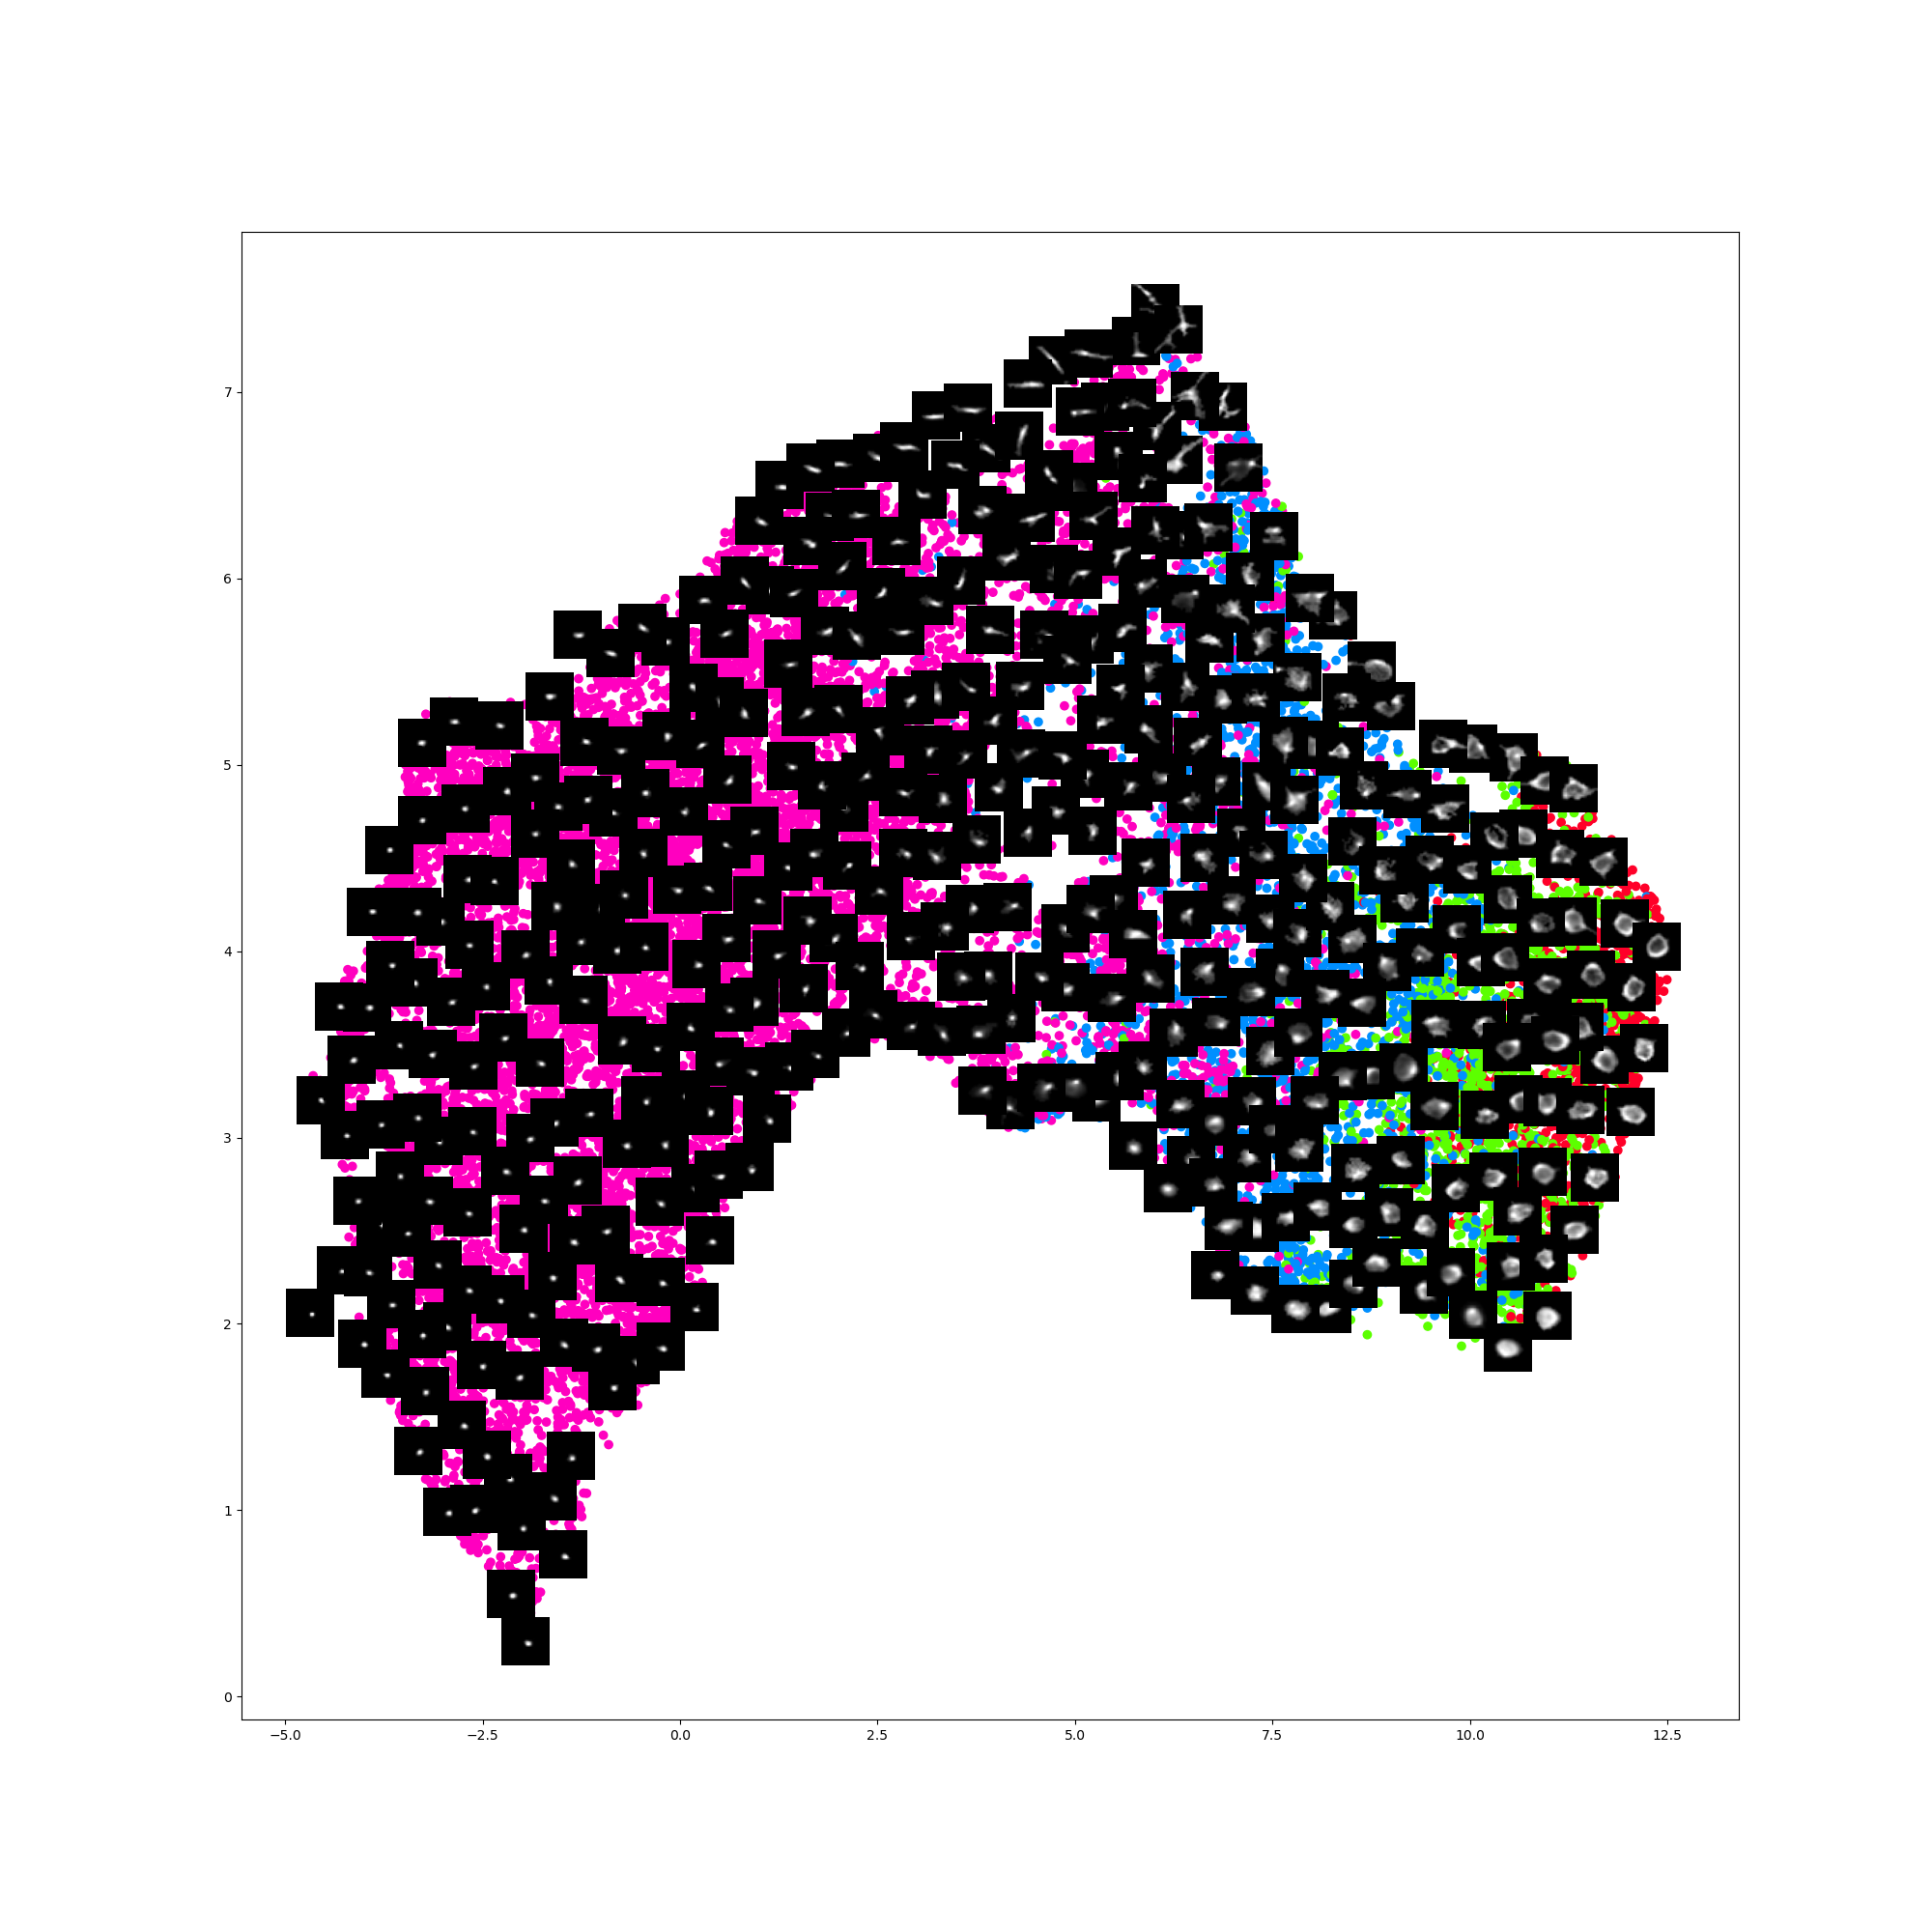

In [51]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(img):
    return OffsetImage(img, cmap='gray')

x, y, ims_subset = emb_umap[idx_good,0], emb_umap[idx_good,1], sf_concat_rs[idx_good]

fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(emb_umap[:,0], emb_umap[:,1], cmap=plt.get_cmap('gist_rainbow'), c=labels_cat)

for x0, y0, path in zip(x, y, ims_subset):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)